In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.model_selection import KFold


In [2]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2021-08-21 12:29:49--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2021-08-21 12:29:50 (86.9 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2021-08-21 12:29:50--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regre

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
#Initializing a seed for the random varibles
torch.manual_seed(968)

**Network definition**

In [5]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
   
    def reset_weights(self):
      torch.nn.init.xavier_uniform_(self.fc1.weight)
      torch.nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

**Dataset Visualization**

In [6]:
train_df = pd.read_csv('/content/regression_dataset/train_data.csv')
print(train_df)

       input     label
0  -4.787870 -1.216804
1  -3.509057  3.277581
2  -3.855373  2.621375
3  -4.083518  1.046088
4  -4.230588  1.228874
..       ...       ...
95  4.745864  5.839698
96  4.454523  3.584919
97  4.547246  4.586484
98  4.649648  5.185536
99  4.781836  6.616912

[100 rows x 2 columns]


**Analyze the basic statistical values of our dataset**


In [7]:
train_df.describe()

,input,label
count,100.000000,100.000000
mean,0.535661,2.826761
std,3.511726,1.962990
min,-4.915863,-3.742970
25%,-3.255942,1.677844
50%,0.037716,2.663394
75%,4.143882,3.727911
max,4.977516,7.199304


In [8]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


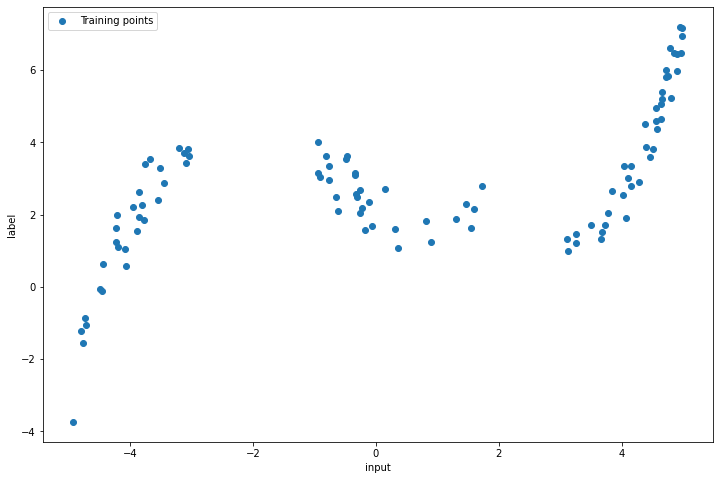

In [9]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

In [10]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


**Training Regression + Cross validation** 

In [12]:
#random permutation of the training set
torch_tensor_x = torch.tensor(train_df['input'].values)
torch_tensor_y = torch.tensor(train_df['label'].values)
permutation = np.random.permutation(100)
x_train = torch_tensor_x[permutation]
y_train = torch_tensor_y[permutation]

#Defining parameters
batch_size=16
n_split=3
num_epochs = 2000
train_loss_log = []
val_loss_log = []
train_loss_fold=[]
val_loss_fold=[]
list_out=[]
#Initializing the network
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1
net = Net(Ni, Nh1, Nh2, No)
net.to(device)

# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-2)
kf = KFold(n_splits=n_split)
i=0
for train_index, val_index in kf.split(x_train, y_train):  
    i+=1
    net.reset_weights()
    print('Fold number %d' %(i))
    x_train_fold = x_train[train_index] 
    y_train_fold = y_train[train_index] 
    x_val_fold = x_train[val_index] 
    y_val_fold = y_train[val_index] 
    #print(x_train_fold)
    #print(x_val_fold)
    #so now x_train_fold,y_train_fold contain the training set as a torch tensor and x_val_fold, y_val_fold contain the validation set as tensor.

    #DataLoader
    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    val = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False,num_workers=0)
    val_loader = torch.utils.data.DataLoader(val, batch_size = len(val), shuffle =False ,num_workers=0)
    #start the training
    for epoch_num in range(num_epochs):
        print('#################')
        print(f'# EPOCH {epoch_num} ')
        print(f'#FOLD {i}')
        print('#################')

        ### TRAIN
        train_loss= []
        net.train() # Training mode (e.g. enable dropout)
        for batch_index, (xx_batch, y_batch) in enumerate(train_loader):
          # Move data to device
          x_batch = xx_batch.to(device)
          label_batch = y_batch.to(device)
          x_batch=torch.unsqueeze(x_batch, 1)
          label_batch= torch.unsqueeze(label_batch, 1)

          # Forward pass
          x_batch = x_batch.view(x_batch.size(0), -1)
          out = net(x_batch.float())

          # Compute loss
          
          loss = loss_fn(out, label_batch.float())
          loss=loss

          # Backpropagation
          net.zero_grad()
          loss.backward()

          # Update the weights
          optimizer.step()

          # Save train loss for this batch
          loss_batch = loss.detach().cpu().numpy()
          train_loss.append(loss_batch)

        # Save average train loss
        train_loss = np.mean(train_loss)
        print(f"AVERAGE TRAIN LOSS: {train_loss}")
        train_loss_log.append(train_loss)

        ### VALIDATION
        val_loss= []
        net.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
          for batch_index, (xx_batch, y_batch) in enumerate(val_loader):
            # Move data to device
            x_batch = xx_batch.to(device)
            label_batch = y_batch.to(device)
            x_batch=torch.unsqueeze(x_batch, 1)
            label_batch= torch.unsqueeze(label_batch, 1)

            # Forward pass
            x_batch = x_batch.view(x_batch.size(0), -1)
            out = net(x_batch.float())

            # Compute loss
            loss = loss_fn(out, label_batch.float())

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

          # Save average validation loss
          val_loss = np.mean(val_loss)
          print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
          val_loss_log.append(val_loss)
    ### Save network parameters after each fold
    net_state_dict = net.state_dict()
    # Save the state dict to a file
    torch.save(net_state_dict, 'net_parameters.torch %d' %i)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
AVERAGE TRAIN LOSS: 0.2032877653837204
AVERAGE VAL LOSS: 0.36263224482536316
#################
# EPOCH 1167 
#FOLD 3
#################
AVERAGE TRAIN LOSS: 0.20375072956085205
AVERAGE VAL LOSS: 0.2956448197364807
#################
# EPOCH 1168 
#FOLD 3
#################
AVERAGE TRAIN LOSS: 0.2060503214597702
AVERAGE VAL LOSS: 0.4073171019554138
#################
# EPOCH 1169 
#FOLD 3
#################
AVERAGE TRAIN LOSS: 0.18216849863529205
AVERAGE VAL LOSS: 0.3083352744579315
#################
# EPOCH 1170 
#FOLD 3
#################
AVERAGE TRAIN LOSS: 0.1821000725030899
AVERAGE VAL LOSS: 0.34243422746658325
#################
# EPOCH 1171 
#FOLD 3
#################
AVERAGE TRAIN LOSS: 0.18706241250038147
AVERAGE VAL LOSS: 0.3540166914463043
#################
# EPOCH 1172 
#FOLD 3
#################
AVERAGE TRAIN LOSS: 0.18523916602134705
AVERAGE VAL LOSS: 0.33581802248954773
#################
# EPOCH 1173 
#FO

In [16]:
len(train_loss_log)

6000

**Plot** **loss**

In [15]:
# Define the list of losses for each split 
j=0
for i in range (0,6000,2000):
  j+=1
  globals()['train_loss_log%d' % j] =train_loss_log[i:i+2000]
  globals()['val_loss_log%d' % j] =val_loss_log[i:i+2000]


In [26]:
TrainFold1Loss=train_loss_log1[-1]
ValFold1Loss=val_loss_log1[-1]
TrainFold2Loss=train_loss_log2[-1]
ValFold2Loss=val_loss_log2[-1]
TrainFold3Loss=train_loss_log3[-1]
ValFold3Loss=val_loss_log3[-1]
print('FOLD1')
print(TrainFold1Loss)
print(ValFold1Loss)
print('FOLD2')
print(TrainFold2Loss)
print(ValFold2Loss)
print('FOLD3')
print(TrainFold3Loss)
print(ValFold3Loss)


FOLD1
0.2429488
0.4173703
FOLD2
0.13003038
0.58391374
FOLD3
0.1681982
0.36142215


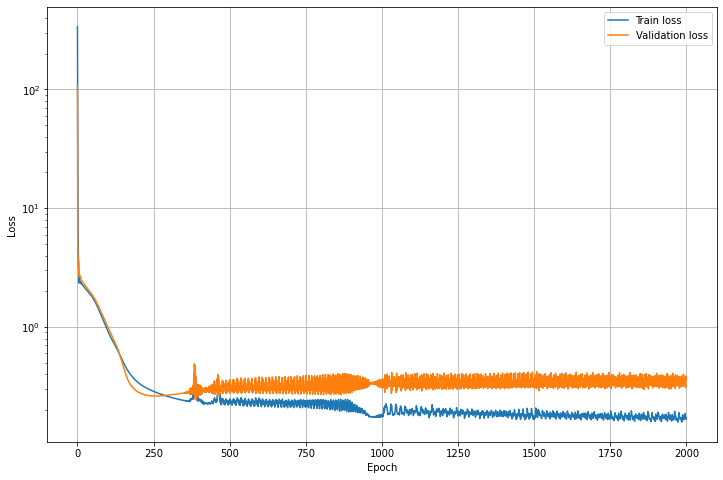

In [28]:
# Plot losses
plt.figure(figsize=(12,8))

plt.semilogy(train_loss_log3, label='Train loss') #feel free to change 7 to any other number between 1 and 10
plt.semilogy(val_loss_log3, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

**Plotting the *final* model**

In [29]:
### Reload the network state
# Load the state dict previously saved
net = Net(Ni, Nh1, Nh2, No) 
net_state_dict = torch.load('net_parameters.torch 3')
# Update the network parameters
net.load_state_dict(net_state_dict)
net=net.to(device)

Network initialized


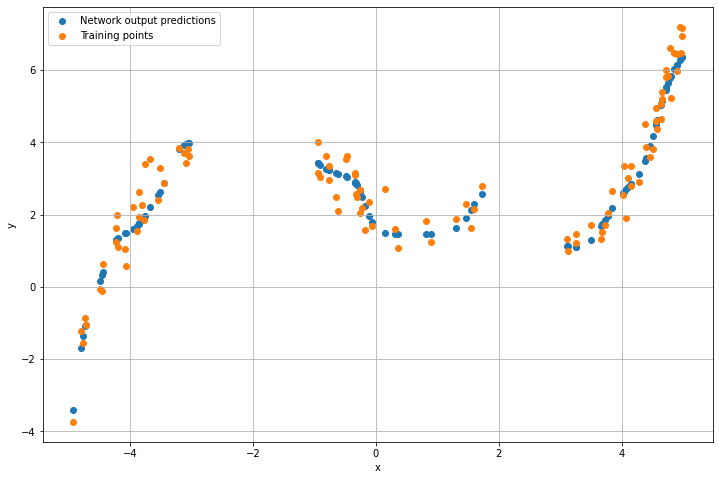

In [32]:
x_vec=train_df['input'].values
x_vec=torch.tensor(x_vec)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)

with torch.no_grad():
  y_vec = net(x_vec.float())

y_vec= y_vec.squeeze().cpu().numpy()
x_vec = x_vec.squeeze().cpu().numpy()

plt.figure(figsize=(12,8))
plt.scatter(x_vec, y_vec, label='Network output predictions')
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()


**Testing**

In [33]:
test_df = pd.read_csv('/content/regression_dataset/test_data.csv')
print(test_df)
print(len(test_df))

       input     label
0  -0.623168  2.908782
1   4.613433  4.961119
2   4.233314  3.403159
3  -4.555919 -0.606397
4   2.894684  1.397028
..       ...       ...
95 -2.029013  4.130353
96  0.313855  1.835889
97 -3.108990  3.434612
98 -0.213557  2.281842
99  3.842187  2.013707

[100 rows x 2 columns]
100


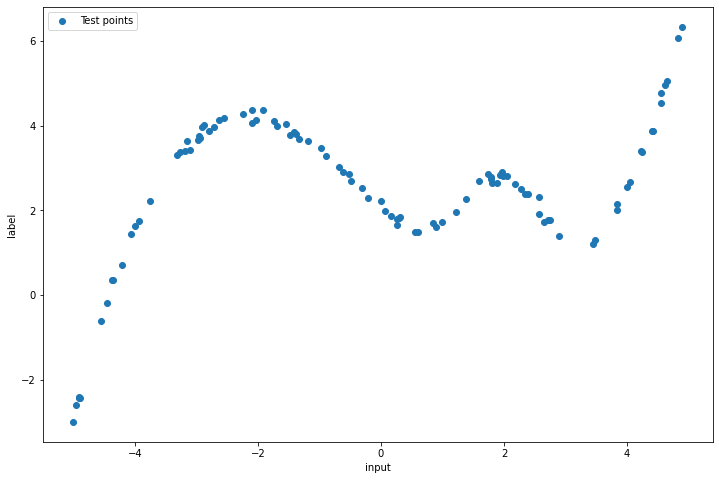

In [34]:
#Plotting test set
fig = plt.figure(figsize=(12,8))
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

In [35]:
class CsvDataset(Dataset):

  def __init__(self, csv_file, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    # Read the file and split the lines in a list
    with open(csv_file, 'r') as f:
      next(f)
      lines = f.read().split('\n')
    # Get x and y values from each line and append to self.data
    self.data = []
    i=0
    for line in lines:
      if(i<100):
        sample = line.split(',')
        self.data.append((float(sample[0]), float(sample[1])))
        i+=1
    print(self.data)
    # Now self.data contains all our dataset.
    # Each element of the list self.data is a tuple: (input, output)

  def __len__(self):
    # The length of the dataset is simply the length of the self.data list
    return len(self.data)

  def __getitem__(self, idx):
    # Our sample is the element idx of the list self.data
    sample = self.data[idx]
    if self.transform:
        sample = self.transform(sample)
    return sample

In [36]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor([x]).float(),
                torch.Tensor([y]).float())

In [37]:
composed_transform = transforms.Compose([ToTensor()])
test_dataset  = CsvDataset('/content/regression_dataset/test_data.csv', transform=composed_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False,num_workers=0)


[(-0.6231675406149462, 2.9087815185148878), (4.613433376388237, 4.961118788436131), (4.233314376526877, 3.4031590776543372), (-4.555919250097348, -0.6063969972731267), (2.894684263706755, 1.397027611825461), (-4.896136646330326, -2.4351314439225202), (-1.9246747630539773, 4.375016310250146), (-3.1486955626704427, 3.6421525793126723), (1.5942763905899806, 2.6913378351822357), (-0.30798328423268373, 2.5373858074822873), (0.2875453988824379, 1.822509291506494), (-3.31411378326342, 3.3058175248623964), (-4.901344736490502, -2.4125457906705106), (1.9832678591645525, 2.7989902399122943), (-0.48758796303868035, 2.6897037174426677), (2.5672125613761114, 2.30418343813432), (3.8412844865894638, 2.1385751906720984), (4.558564907220784, 4.76823560570816), (-2.1034052936211656, 4.055769652380439), (-1.3323843534509883, 3.6948092189185036), (-2.8722684427772514, 4.022905514736294), (-2.9449007426141205, 3.699348763073657), (-0.679382382098769, 3.0289438661539854), (1.940698214750225, 2.8420324224339

**Test** 

In [42]:
listCV_loss=[]
min_loss=100
n_best_split=0
net.eval() # Evaluation mode (e.g. disable dropout)
for i in range(n_split):
  #load the weights of the network i
  net = Net(Ni, Nh1, Nh2, No) 
  n=i+1
  net_state_dict = torch.load('/content/net_parameters.torch %d' %n)
  net.load_state_dict(net_state_dict)
  net=net.to(device)
  all_inputs = []
  all_outputs = []
  all_labels = []
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_loader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      # Forward pass
      out = net(x_batch)
      # Save outputs and labels
      all_inputs.append(x_batch)
      all_outputs.append(out)
      all_labels.append(label_batch)
  # Concatenate all the outputs and labels in a single tensor
  all_inputs  = torch.cat(all_inputs)
  all_outputs = torch.cat(all_outputs)
  all_labels  = torch.cat(all_labels)
  
  test_loss = loss_fn(all_outputs, all_labels)
  if (test_loss < min_loss):
    min_loss=test_loss
    n_best_split=i
  listCV_loss.append(test_loss)
  print('### MODEL %d ####' %(i))
  print(f"AVERAGE TEST LOSS: {test_loss}")


Network initialized
### MODEL 0 ####
AVERAGE TEST LOSS: 0.20464715361595154
Network initialized
### MODEL 1 ####
AVERAGE TEST LOSS: 0.26183021068573
Network initialized
### MODEL 2 ####
AVERAGE TEST LOSS: 0.12449510395526886


### **Regression + Cross validation + Grid search**




In [54]:
#random permutation of the training set
torch_tensor_x = torch.tensor(train_df['input'].values)
torch_tensor_y = torch.tensor(train_df['label'].values)
permutation = np.random.permutation(100)
x_train = torch_tensor_x[permutation]
y_train = torch_tensor_y[permutation]
#Defining gridsearch space
Space=[(64,128,0.001),(128,256,0.001),(64,128,0.01),(128,256,0.01)]
Models_train_loss=[]
Models_val_loss=[]

for x in Space:
  #Initializing the network
  Ni = 1
  Nh1 = x[0]
  Nh2 = x[1]
  No = 1
  net = Net(Ni, Nh1, Nh2, No)
  net.to(device)

  # Define the loss function
  loss_fn = nn.MSELoss()

  # Define the optimizer
  lr=x[2]
  optimizer = optim.Adam(net.parameters(), lr=lr)
  kf = KFold(n_splits=n_split)

  #Defining parameters
  batch_size=16
  n_split=3
  num_epochs = 3000
  train_loss_log = []
  val_loss_log = []
  train_loss_fold=[]
  val_loss_fold=[]
  
  i=0
  for train_index, val_index in kf.split(x_train, y_train):  
    i+=1
    net.reset_weights()
    print('Fold number %d' %(i))
    x_train_fold = x_train[train_index] 
    y_train_fold = y_train[train_index] 
    x_val_fold = x_train[val_index] 
    y_val_fold = y_train[val_index] 
    #print(x_train_fold)
    #print(x_val_fold)
    #so now x_train_fold,y_train_fold contain the training set as a torch tensor and x_val_fold, y_val_fold contain the validation set as tensor.

    #DataLoader
    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    val = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False,num_workers=0)
    val_loader = torch.utils.data.DataLoader(val, batch_size = len(val), shuffle =False ,num_workers=0)
    #start the training
    for epoch_num in range(num_epochs):
        print('#################')
        print(f'# EPOCH {epoch_num} ')
        print(f'#FOLD {i}')
        print('#################')

        ### TRAIN
        train_loss= []
        net.train() # Training mode (e.g. enable dropout)
        for batch_index, (xx_batch, y_batch) in enumerate(train_loader):
          # Move data to device
          x_batch = xx_batch.to(device)
          label_batch = y_batch.to(device)
          x_batch=torch.unsqueeze(x_batch, 1)
          label_batch= torch.unsqueeze(label_batch, 1)

          # Forward pass
          x_batch = x_batch.view(x_batch.size(0), -1)
          out = net(x_batch.float())

          # Compute loss
          
          loss = loss_fn(out, label_batch.float())
          loss=loss

          # Backpropagation
          net.zero_grad()
          loss.backward()

          # Update the weights
          optimizer.step()

          # Save train loss for this batch
          loss_batch = loss.detach().cpu().numpy()
          train_loss.append(loss_batch)

        # Save average train loss
        train_loss = np.mean(train_loss)
        print(f"AVERAGE TRAIN LOSS: {train_loss}")

        ### VALIDATION
        val_loss= []
        net.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
          for batch_index, (xx_batch, y_batch) in enumerate(val_loader):
            # Move data to device
            x_batch = xx_batch.to(device)
            label_batch = y_batch.to(device)
            x_batch=torch.unsqueeze(x_batch, 1)
            label_batch= torch.unsqueeze(label_batch, 1)

            # Forward pass
            x_batch = x_batch.view(x_batch.size(0), -1)
            out = net(x_batch.float())

            # Compute loss
            loss = loss_fn(out, label_batch.float())

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

          # Save average validation loss
          val_loss = np.mean(val_loss)
          print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
    #save losses
    train_loss_log.append(train_loss)
    val_loss_log.append(val_loss)
    ### Save network parameters after each fold
    net_state_dict = net.state_dict()
    # Save the state dict to a file
    torch.save(net_state_dict, "net_parametersFold {} Space {}".format(i, x))
  Models_train_loss.append(np.mean(train_loss_log))
  Models_val_loss.append(np.mean(val_loss_log))


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
AVERAGE TRAIN LOSS: 0.3003598749637604
AVERAGE VAL LOSS: 0.3016986846923828
#################
# EPOCH 2167 
#FOLD 3
#################
AVERAGE TRAIN LOSS: 0.24898095428943634
AVERAGE VAL LOSS: 0.32787057757377625
#################
# EPOCH 2168 
#FOLD 3
#################
AVERAGE TRAIN LOSS: 0.30033841729164124
AVERAGE VAL LOSS: 0.3017030954360962
#################
# EPOCH 2169 
#FOLD 3
#################
AVERAGE TRAIN LOSS: 0.24896535277366638
AVERAGE VAL LOSS: 0.3278673589229584
#################
# EPOCH 2170 
#FOLD 3
#################
AVERAGE TRAIN LOSS: 0.3003167510032654
AVERAGE VAL LOSS: 0.3017078638076782
#################
# EPOCH 2171 
#FOLD 3
#################
AVERAGE TRAIN LOSS: 0.24894952774047852
AVERAGE VAL LOSS: 0.3278641402721405
#################
# EPOCH 2172 
#FOLD 3
#################
AVERAGE TRAIN LOSS: 0.30029481649398804
AVERAGE VAL LOSS: 0.3017124533653259
#################
# EPOCH 2173 
#FOL

In [55]:
print(Models_train_loss)

[0.37044778, 0.37973607, 0.14336367, 0.17349274]


In [56]:
print(Models_val_loss)

[0.39823258, 0.4255147, 0.3561332, 0.37197986]


In [59]:
net.eval() # Evaluation mode (e.g. disable dropout)
#load the weights of the network i
net = Net(Ni, 64, 128, No) 
net_state_dict = torch.load('/content/net_parametersFold 3 Space (64, 128, 0.01)')
net.load_state_dict(net_state_dict)
net=net.to(device)
all_inputs = []
all_outputs = []
all_labels = []
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_loader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      # Forward pass
      out = net(x_batch)
      # Save outputs and labels
      all_inputs.append(x_batch)
      all_outputs.append(out)
      all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)
  
test_loss = loss_fn(all_outputs, all_labels)

Network initialized


### **Classification Task**

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.model_selection import KFold

In [62]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [64]:
#Initializing a seed for the random varibles
torch.manual_seed(0)

In [65]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)
print(len(train_dataset))
print(len(test_dataset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw

60000
10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


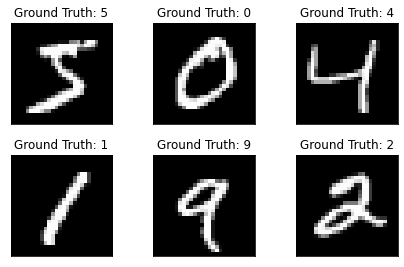

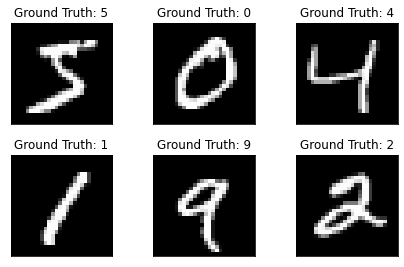

In [67]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_dataset[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(train_dataset[i][1]))
  plt.xticks([])
  plt.yticks([])
fig

Definition of the network

In [74]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64,64, kernel_size=5)
        self.conv3 = nn.Conv2d(64,128, kernel_size=5)
        self.fc1 = nn.Linear(3*3*128,256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*128 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


Laod the dataset

In [69]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [72]:
x_train=[]
y_train=[]

trainset=[]
testset=[]

for sample in train_dataset:
     x_train.append(np.array(sample[0]))
     y_train.append(np.array(sample[1]))
     trainset.append([torch.from_numpy(np.array(sample[0])),torch.from_numpy(np.array(sample[1])).long()])
for samplet in test_dataset:
     testset.append([torch.from_numpy(np.array(samplet[0])),torch.from_numpy(np.array(samplet[1])).long()])

dataset_train=trainset
dataset_test=testset
print("x_train =",trainset[0][0].shape)
dataloader=DataLoader(dataset=dataset_train,
                         batch_size=64,
                         shuffle=True,
                         )
dataloader_test=DataLoader(dataset=dataset_test,
                         batch_size=64,
                         shuffle=True,
                         ) 


x_train = torch.Size([28, 28])


Training the network + Cross validation

Epoch 0  - Average Training loss: 0.5701873302459717
-------------------
AVERAGE VAL LOSS: 0.08142513036727905
val accuracy:0.974% 
Epoch 1  - Average Training loss: 0.17899465560913086
-------------------
AVERAGE VAL LOSS: 0.07220954447984695
val accuracy:0.978% 
Epoch 2  - Average Training loss: 0.15731334686279297
-------------------
AVERAGE VAL LOSS: 0.06513284146785736
val accuracy:0.978% 
Epoch 3  - Average Training loss: 0.15347324311733246
-------------------
AVERAGE VAL LOSS: 0.05229131132364273
val accuracy:0.982% 
Epoch 4  - Average Training loss: 0.1581135243177414
-------------------
AVERAGE VAL LOSS: 0.06116064637899399
val accuracy:0.979% 
Epoch 5  - Average Training loss: 0.14589884877204895
-------------------
AVERAGE VAL LOSS: 0.054326143115758896
val accuracy:0.983% 
Epoch 6  - Average Training loss: 0.1439179629087448
-------------------
AVERAGE VAL LOSS: 0.05355583503842354
val accuracy:0.982% 
Epoch 7  - Average Training loss: 0.15200215578079224
-----------------

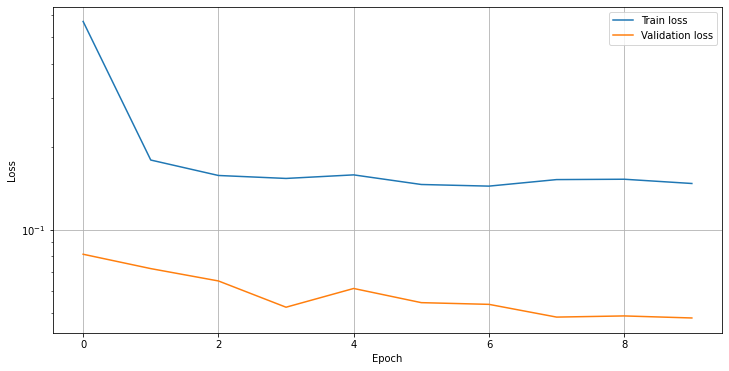

Epoch 0  - Average Training loss: 0.5423018336296082
-------------------
AVERAGE VAL LOSS: 0.08585590124130249
val accuracy:0.971% 
Epoch 1  - Average Training loss: 0.17369350790977478
-------------------
AVERAGE VAL LOSS: 0.07104383409023285
val accuracy:0.979% 
Epoch 2  - Average Training loss: 0.15177731215953827
-------------------
AVERAGE VAL LOSS: 0.05893729254603386
val accuracy:0.980% 
Epoch 3  - Average Training loss: 0.14496183395385742
-------------------
AVERAGE VAL LOSS: 0.05326010286808014
val accuracy:0.984% 
Epoch 4  - Average Training loss: 0.13665452599525452
-------------------
AVERAGE VAL LOSS: 0.058946285396814346
val accuracy:0.979% 
Epoch 5  - Average Training loss: 0.14565794169902802
-------------------
AVERAGE VAL LOSS: 0.053387757390737534
val accuracy:0.983% 
Epoch 6  - Average Training loss: 0.14887219667434692
-------------------
AVERAGE VAL LOSS: 0.053319793194532394
val accuracy:0.982% 
Epoch 7  - Average Training loss: 0.14721757173538208
-------------

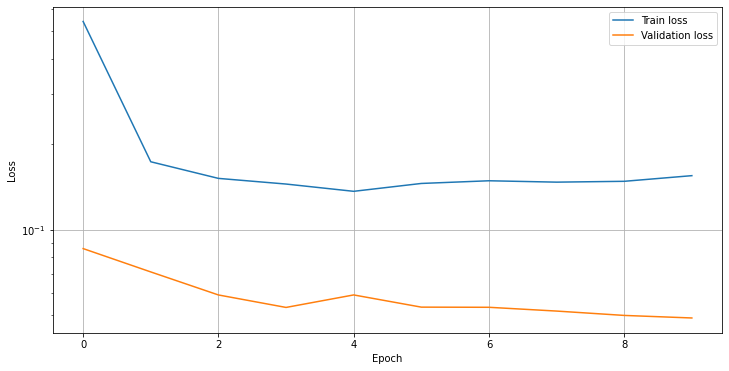

Epoch 0  - Average Training loss: 0.5874301791191101
-------------------
AVERAGE VAL LOSS: 0.08375374972820282
val accuracy:0.974% 
Epoch 1  - Average Training loss: 0.1886872947216034
-------------------
AVERAGE VAL LOSS: 0.05581697076559067
val accuracy:0.980% 
Epoch 2  - Average Training loss: 0.16408249735832214
-------------------
AVERAGE VAL LOSS: 0.056116119027137756
val accuracy:0.981% 
Epoch 3  - Average Training loss: 0.15706320106983185
-------------------
AVERAGE VAL LOSS: 0.04522905871272087
val accuracy:0.983% 
Epoch 4  - Average Training loss: 0.15598370134830475
-------------------
AVERAGE VAL LOSS: 0.0438581258058548
val accuracy:0.985% 
Epoch 5  - Average Training loss: 0.15159565210342407
-------------------
AVERAGE VAL LOSS: 0.044025909155607224
val accuracy:0.986% 
Epoch 6  - Average Training loss: 0.15406274795532227
-------------------
AVERAGE VAL LOSS: 0.055091749876737595
val accuracy:0.982% 
Epoch 7  - Average Training loss: 0.15149721503257751
---------------

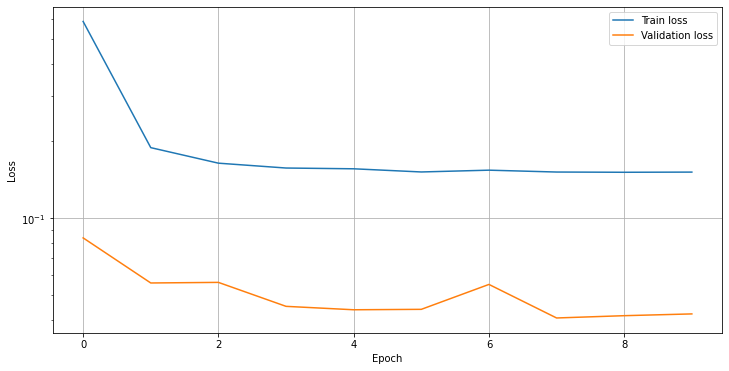

Epoch 0  - Average Training loss: 0.6832732558250427
-------------------
AVERAGE VAL LOSS: 0.08334363251924515
val accuracy:0.974% 
Epoch 1  - Average Training loss: 0.2083035558462143
-------------------
AVERAGE VAL LOSS: 0.06884041428565979
val accuracy:0.978% 
Epoch 2  - Average Training loss: 0.1728644222021103
-------------------
AVERAGE VAL LOSS: 0.06330583989620209
val accuracy:0.979% 
Epoch 3  - Average Training loss: 0.15638968348503113
-------------------
AVERAGE VAL LOSS: 0.0544734001159668
val accuracy:0.981% 
Epoch 4  - Average Training loss: 0.162999227643013
-------------------
AVERAGE VAL LOSS: 0.05181226506829262
val accuracy:0.982% 
Epoch 5  - Average Training loss: 0.15885676443576813
-------------------
AVERAGE VAL LOSS: 0.05497594177722931
val accuracy:0.981% 
Epoch 6  - Average Training loss: 0.15452615916728973
-------------------
AVERAGE VAL LOSS: 0.046207454055547714
val accuracy:0.984% 
Epoch 7  - Average Training loss: 0.16090501844882965
-------------------


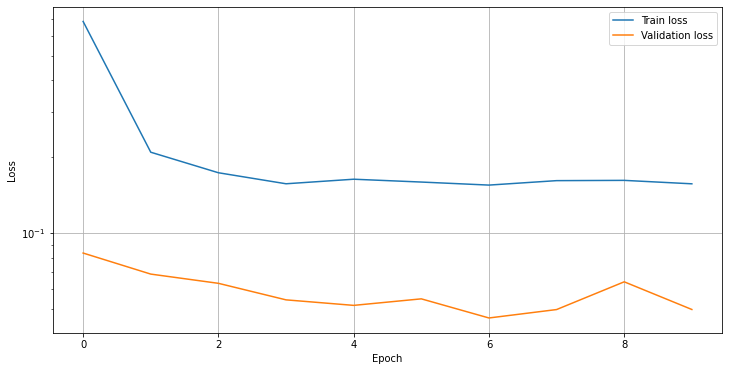

Epoch 0  - Average Training loss: 0.7166494131088257
-------------------
AVERAGE VAL LOSS: 0.12117214500904083
val accuracy:0.967% 
Epoch 1  - Average Training loss: 0.21090048551559448
-------------------
AVERAGE VAL LOSS: 0.07501933723688126
val accuracy:0.977% 
Epoch 2  - Average Training loss: 0.15949514508247375
-------------------
AVERAGE VAL LOSS: 0.06689195334911346
val accuracy:0.979% 
Epoch 3  - Average Training loss: 0.15682968497276306
-------------------
AVERAGE VAL LOSS: 0.060437243431806564
val accuracy:0.980% 
Epoch 4  - Average Training loss: 0.15512457489967346
-------------------
AVERAGE VAL LOSS: 0.051157429814338684
val accuracy:0.981% 
Epoch 5  - Average Training loss: 0.152136892080307
-------------------
AVERAGE VAL LOSS: 0.05487186834216118
val accuracy:0.980% 
Epoch 6  - Average Training loss: 0.16019827127456665
-------------------
AVERAGE VAL LOSS: 0.06148146092891693
val accuracy:0.984% 
Epoch 7  - Average Training loss: 0.15127871930599213
----------------

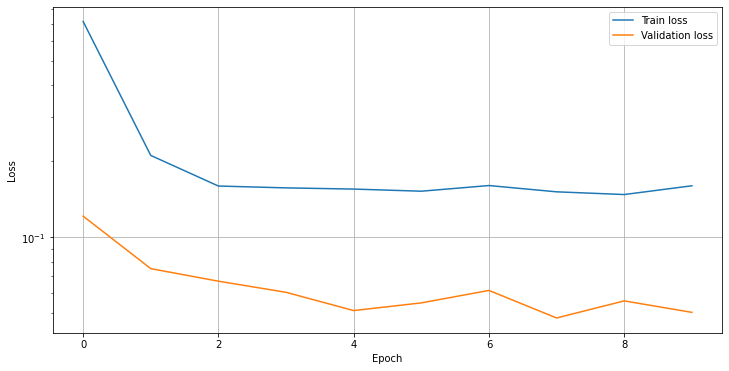

Epoch 0  - Average Training loss: 0.5257514715194702
-------------------
AVERAGE VAL LOSS: 0.0980217233300209
val accuracy:0.969% 
Epoch 1  - Average Training loss: 0.17916516959667206
-------------------
AVERAGE VAL LOSS: 0.06351063400506973
val accuracy:0.978% 
Epoch 2  - Average Training loss: 0.15769922733306885
-------------------
AVERAGE VAL LOSS: 0.05846381187438965
val accuracy:0.982% 
Epoch 3  - Average Training loss: 0.15079155564308167
-------------------
AVERAGE VAL LOSS: 0.04932117089629173
val accuracy:0.982% 
Epoch 4  - Average Training loss: 0.14898192882537842
-------------------
AVERAGE VAL LOSS: 0.051985785365104675
val accuracy:0.983% 
Epoch 5  - Average Training loss: 0.14990508556365967
-------------------
AVERAGE VAL LOSS: 0.051333822309970856
val accuracy:0.983% 
Epoch 6  - Average Training loss: 0.15846580266952515
-------------------
AVERAGE VAL LOSS: 0.04812745377421379
val accuracy:0.985% 
Epoch 7  - Average Training loss: 0.14818279445171356
---------------

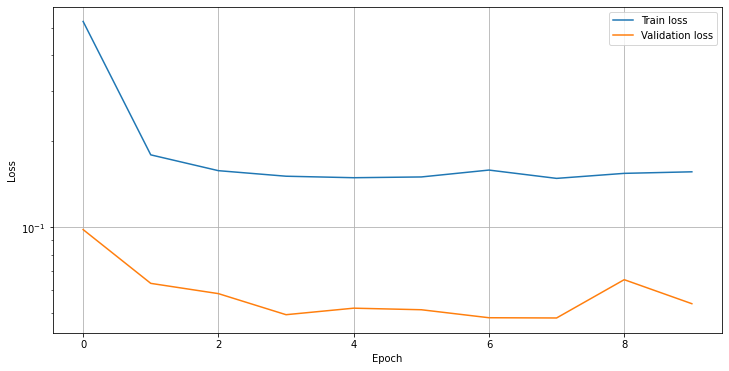

Epoch 0  - Average Training loss: 0.5609887838363647
-------------------
AVERAGE VAL LOSS: 0.08043073862791061
val accuracy:0.976% 
Epoch 1  - Average Training loss: 0.17615914344787598
-------------------
AVERAGE VAL LOSS: 0.0626896321773529
val accuracy:0.980% 
Epoch 2  - Average Training loss: 0.15395599603652954
-------------------
AVERAGE VAL LOSS: 0.06067228317260742
val accuracy:0.979% 
Epoch 3  - Average Training loss: 0.15402360260486603
-------------------
AVERAGE VAL LOSS: 0.052125584334135056
val accuracy:0.982% 
Epoch 4  - Average Training loss: 0.15032346546649933
-------------------
AVERAGE VAL LOSS: 0.04962044581770897
val accuracy:0.983% 
Epoch 5  - Average Training loss: 0.1469491720199585
-------------------
AVERAGE VAL LOSS: 0.054586540907621384
val accuracy:0.981% 
Epoch 6  - Average Training loss: 0.1544540673494339
-------------------
AVERAGE VAL LOSS: 0.050911057740449905
val accuracy:0.983% 
Epoch 7  - Average Training loss: 0.14678293466567993
----------------

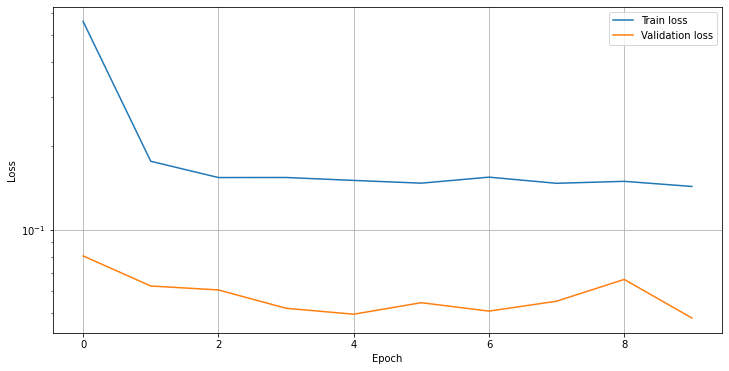

Epoch 0  - Average Training loss: 0.6009576320648193
-------------------
AVERAGE VAL LOSS: 0.08595272898674011
val accuracy:0.970% 
Epoch 1  - Average Training loss: 0.19270722568035126
-------------------
AVERAGE VAL LOSS: 0.06573773920536041
val accuracy:0.978% 
Epoch 2  - Average Training loss: 0.16116994619369507
-------------------
AVERAGE VAL LOSS: 0.055010370910167694
val accuracy:0.981% 
Epoch 3  - Average Training loss: 0.15295885503292084
-------------------
AVERAGE VAL LOSS: 0.05421823263168335
val accuracy:0.980% 
Epoch 4  - Average Training loss: 0.1540989875793457
-------------------
AVERAGE VAL LOSS: 0.06230096518993378
val accuracy:0.978% 
Epoch 5  - Average Training loss: 0.15440574288368225
-------------------
AVERAGE VAL LOSS: 0.06885930150747299
val accuracy:0.979% 
Epoch 6  - Average Training loss: 0.14996309578418732
-------------------
AVERAGE VAL LOSS: 0.051613789051771164
val accuracy:0.981% 
Epoch 7  - Average Training loss: 0.15156136453151703
---------------

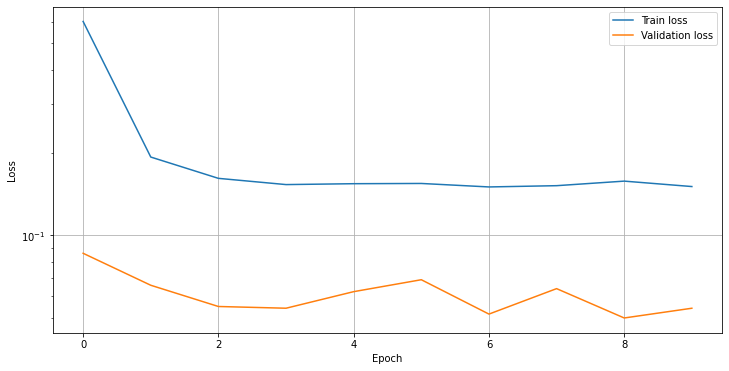

Epoch 0  - Average Training loss: 0.6296294331550598
-------------------
AVERAGE VAL LOSS: 0.13256391882896423
val accuracy:0.960% 
Epoch 1  - Average Training loss: 0.19673188030719757
-------------------
AVERAGE VAL LOSS: 0.0830296128988266
val accuracy:0.977% 
Epoch 2  - Average Training loss: 0.16586311161518097
-------------------
AVERAGE VAL LOSS: 0.06536740064620972
val accuracy:0.979% 
Epoch 3  - Average Training loss: 0.16003920137882233
-------------------
AVERAGE VAL LOSS: 0.07339474558830261
val accuracy:0.975% 
Epoch 4  - Average Training loss: 0.15081335604190826
-------------------
AVERAGE VAL LOSS: 0.053602613508701324
val accuracy:0.986% 
Epoch 5  - Average Training loss: 0.15110428631305695
-------------------
AVERAGE VAL LOSS: 0.056712280958890915
val accuracy:0.982% 
Epoch 6  - Average Training loss: 0.15481361746788025
-------------------
AVERAGE VAL LOSS: 0.05355033650994301
val accuracy:0.983% 
Epoch 7  - Average Training loss: 0.15665189921855927
---------------

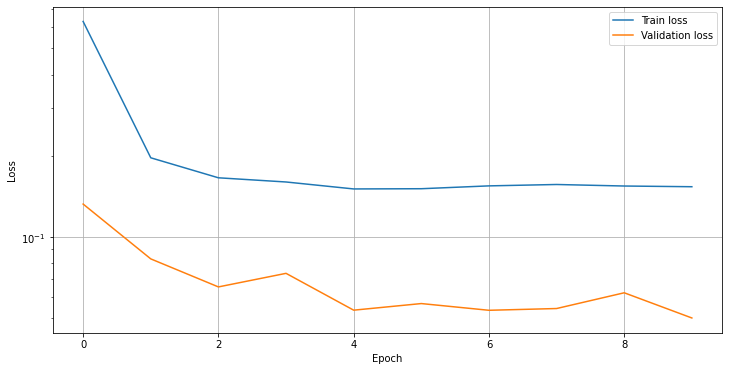

Epoch 0  - Average Training loss: 0.62123042345047
-------------------
AVERAGE VAL LOSS: 0.06518644094467163
val accuracy:0.978% 
Epoch 1  - Average Training loss: 0.19518807530403137
-------------------
AVERAGE VAL LOSS: 0.059165481477975845
val accuracy:0.981% 
Epoch 2  - Average Training loss: 0.16671453416347504
-------------------
AVERAGE VAL LOSS: 0.04743411764502525
val accuracy:0.985% 
Epoch 3  - Average Training loss: 0.16083624958992004
-------------------
AVERAGE VAL LOSS: 0.05041198059916496
val accuracy:0.983% 
Epoch 4  - Average Training loss: 0.16161002218723297
-------------------
AVERAGE VAL LOSS: 0.045394111424684525
val accuracy:0.984% 
Epoch 5  - Average Training loss: 0.15557453036308289
-------------------
AVERAGE VAL LOSS: 0.04657164588570595
val accuracy:0.986% 
Epoch 6  - Average Training loss: 0.1542506068944931
-------------------
AVERAGE VAL LOSS: 0.03773508965969086
val accuracy:0.986% 
Epoch 7  - Average Training loss: 0.15563364326953888
-----------------

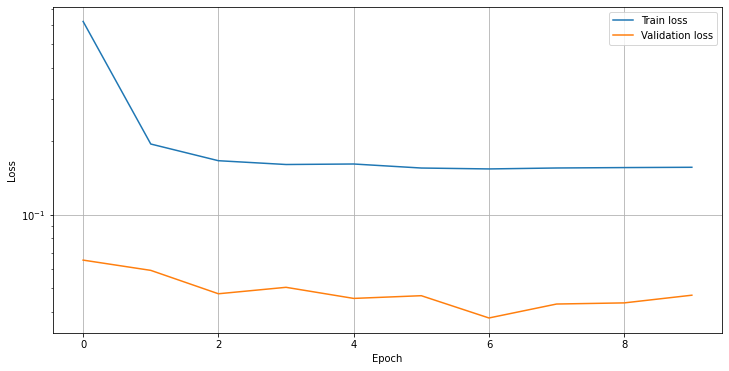

In [126]:
from sklearn.model_selection import KFold
list_accuracy=[]
val_accuracy=0
kfold =KFold(n_splits=10)
for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):  
    cnn = CNN()
    cnn.to(device) 
    optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001, betas=(0.9,0.999))
    criterion = nn.CrossEntropyLoss()
    #prepare train and validation data
    x_train_fold =torch.from_numpy(np.array(x_train)[train_index]) 
    y_train_fold =torch.from_numpy(np.array(y_train)[train_index])
    x_val_fold = torch.from_numpy(np.array(x_train)[val_index])
    y_val_fold =torch.from_numpy(np.array(y_train)[val_index])
    
    trainfold_dataset=TensorDataset(x_train_fold,y_train_fold)
    valfold_dataset=TensorDataset(x_val_fold,y_val_fold)
    dataloader_trainfold=DataLoader(dataset=trainfold_dataset,
                         batch_size=64,
                         shuffle=True,
                         )
    dataloader_valfold=DataLoader(dataset=valfold_dataset,
                         batch_size=64,
                         shuffle=True,
                         ) 
    #train mode
    cnn.train()
    epochs = 10
    train_loss_log=[]
    val_loss_log=[]
    for e in range(epochs):
        running_loss = 0
        correct=0
        train_loss=[]
        val_loss= []
        cnn.train()
        for images, labels in dataloader_trainfold:
            images = images.view(-1,1,28,28).float().to(device)
            labels=labels.to(device)
            # Training pass
            optimizer.zero_grad()
            output = cnn(images)
            loss = criterion(output, labels)
            #This is where the model learns by backpropagating
            loss.backward()
            #And optimizes its weights here
            optimizer.step()
            running_loss += loss.item()
            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        # Save average train loss
        train_loss = np.mean(train_loss)
        train_loss_log.append(train_loss)
        print("Epoch {}  - Average Training loss: {}".format(e, train_loss))
        print('-------------------')
        ### VALIDATION
        cnn.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for images, labels in dataloader_valfold:
               images = images.view(-1,1,28,28).float().to(device)
               labels=labels.to(device)
               # Forward pass
               out = cnn(images)
               #acc
               predicted = torch.max(out,1)[1]
               correct += (predicted == labels).sum()
               # Compute loss
               loss = criterion(out, labels)
               # Save val loss for this batch
               loss_batch = loss.detach().cpu().numpy()
               val_loss.append(loss_batch)
        val_loss = np.mean(val_loss)
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        val_accuracy+=float(correct) / (len(dataloader_valfold)*64)
        print("val accuracy:{:.3f}% ".format( float(correct) / (len(dataloader_valfold)*64)))
        val_loss_log.append(val_loss)
    print(val_accuracy/epochs)
    list_accuracy.append(val_accuracy/epochs)
    val_accuracy=0
    print("Train and validation loss figure")
    plt.figure(figsize=(12,6))
    plt.semilogy(train_loss_log, label='Train loss')
    plt.semilogy(val_loss_log, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()
    Path="/content/ClassificationParametersfold{}.pth".format(fold)
    torch.save(cnn.state_dict(), Path)

In [127]:
print(list_accuracy)

[0.9808011968085107, 0.9811336436170212, 0.9829454787234042, 0.980252659574468, 0.9797539893617021, 0.9806349734042554, 0.9814827127659577, 0.9792719414893616, 0.9788231382978724, 0.983909574468085]


In [81]:
for fold in range(10):
  test_loss=[]
  correct = 0
  net=CNN()
  PATH="/content/ClassificationParametersfold{}.pth".format(fold)
  net.load_state_dict(torch.load(PATH))
  net.to(device) 
  net.eval()
  for test_imgs, test_labels in dataloader_test:
        test_imgs = test_imgs.view(-1,1,28,28).float().to(device)
        test_labels=test_labels.to(device)       
        output = net(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
        loss = criterion(output, test_labels)
               # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        test_loss.append(loss_batch)
  test_loss = np.mean(test_loss)

  print("Result for model{}".format(fold))
  print(f"Average test loss: {test_loss}")
  print("Model Accuracy:{:.3f}% ".format( float(correct) / (len(dataloader_test)*64)))

Result for model0
Average test loss: 0.041622698307037354
Model Accuracy:0.984% 
Result for model1
Average test loss: 0.04018806666135788
Model Accuracy:0.983% 
Result for model2
Average test loss: 0.03984498232603073
Model Accuracy:0.984% 
Result for model3
Average test loss: 0.044787995517253876
Model Accuracy:0.982% 
Result for model4
Average test loss: 0.04010253772139549
Model Accuracy:0.985% 
Result for model5
Average test loss: 0.038741447031497955
Model Accuracy:0.984% 
Result for model6
Average test loss: 0.037113092839717865
Model Accuracy:0.985% 
Result for model7
Average test loss: 0.0419965535402298
Model Accuracy:0.983% 
Result for model8
Average test loss: 0.03924034163355827
Model Accuracy:0.983% 
Result for model9
Average test loss: 0.03375449404120445
Model Accuracy:0.986% 


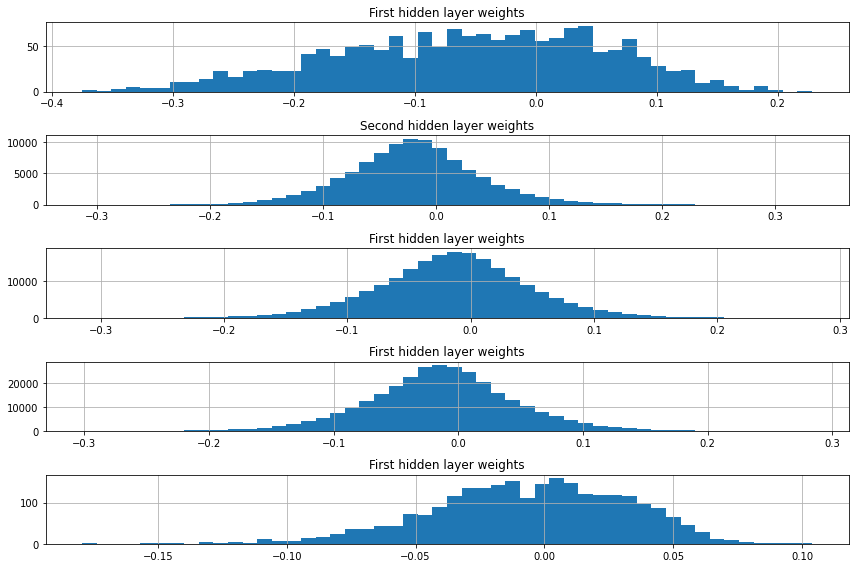

In [83]:
cnn=CNN()
PATH="/content/ClassificationParametersfold9.pth"
cnn.load_state_dict(torch.load(PATH))
cnn.to(device) 
#Access network parameters :
# First hidden layer
h1_w = cnn.conv1.weight.data.cpu().numpy()
h1_b = cnn.conv1.bias.data.cpu().numpy()

# second hidden layer
h2_w = cnn.conv2.weight.data.cpu().numpy()
h2_b = cnn.conv2.bias.data.cpu().numpy()

# third hidden layer
h3_w = cnn.conv3.weight.data.cpu().numpy()
h3_b = cnn.conv3.bias.data.cpu().numpy()

# 4 th hidden layer
h4_w = cnn.fc1.weight.data.cpu().numpy()
h4_b = cnn.fc1.bias.data.cpu().numpy()

# 5 th hidden layer
h5_w = cnn.fc2.weight.data.cpu().numpy()
h5_b = cnn.fc2.bias.data.cpu().numpy()


### plot weights histograms :

fig, axs = plt.subplots(5, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('First hidden layer weights')
axs[3].hist(h4_w.flatten(), 50)
axs[3].set_title('First hidden layer weights')
axs[4].hist(h5_w.flatten(), 50)
axs[4].set_title('First hidden layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

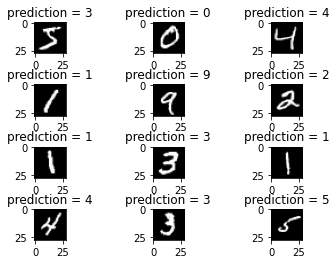

In [87]:
cnn=CNN()
PATH="/content/ClassificationParametersfold9.pth"
cnn.load_state_dict(torch.load(PATH))
cnn.to(device) 
count = 0
for elem in trainset:
  plt.subplot(4,3,count+1)

  image=elem[0]
  true_label=elem[1]
  x=elem[0].view(-1,1,28,28).float().to(device)
  y=elem[1].to(device)
  output = cnn(x)
  predicted_label=torch.max(output,1)[1]
  #fig = plt.figure(figsize=(1,1))
  plt.imshow(image, cmap='gist_gray')
  plt.title("prediction = {}".format(predicted_label.cpu().numpy()[0]))

  count+=1
  if(count==12):
    break

plt.subplots_adjust(hspace=1)

In [103]:
listt=[]
for test_imgs, test_labels in dataloader_test:
        test_imgs = test_imgs.view(-1,1,28,28).float().to(device)
        test_labels=test_labels.to(device)       
        output = net(test_imgs)
        listt.append(test_imgs)

In [94]:
test_imgs.shape

torch.Size([16, 1, 28, 28])

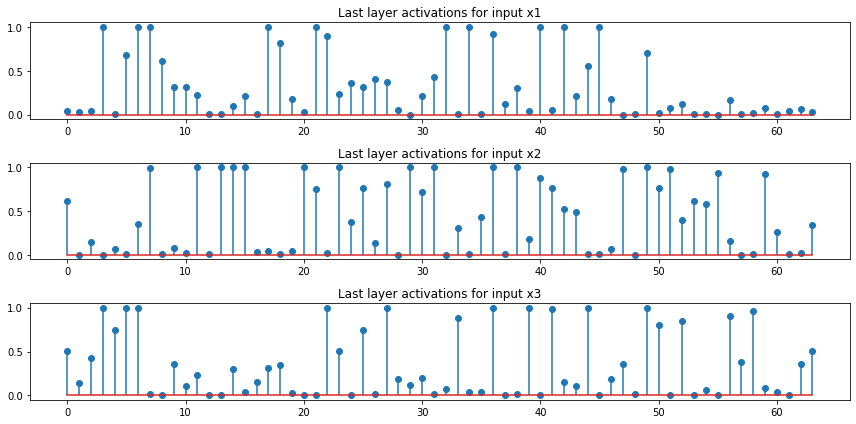

In [125]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = cnn.fc2.register_forward_hook(get_activation)

### Analyze activations
cnn = cnn.to(device)
cnn.eval()
with torch.no_grad():
    x1 = listt[1]
    y1 = cnn(x1)
    z1 = activation
    x2 = listt[2]
    y2 = cnn(x2)
    z2 = activation
    x3 = listt[3]
    y3 = cnn(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1[:,1].cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x1')
axs[1].stem(z2[:,1].cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x2')
axs[2].stem(z3[:,1].cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x3')
plt.tight_layout()
plt.show()